# Sentiment Analysis on Drug review dataset
Data set details here: [Drug Reviews (Druglib.com)](https://archive.ics.uci.edu/dataset/461/drug+review+dataset+druglib+com)

We will use the following:

1) GLoVE Embedding

2) LSTM

3) [Pytorch](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

You can use the following steps to install pytorch(if you do not have already):


!conda install pytorch torchvision -c pytorch
    


In [1]:
import pandas as pd
import numpy as np

#pytorch
import torch
import torch.nn as nn  # Import nn module from PyTorch
import torch.optim as optim #The optim module provides various optimization algorithms that can be used to update the parameters of a neural network during training.
#https://pytorch.org/docs/stable/optim.html

#data viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split  # Import train_test_split


### Step 1 Data Loading and Preprocessing

In [2]:
# Load the training and test datasets
df_train = pd.read_csv("drugLibTrain_raw.tsv", sep="\t")
df_test = pd.read_csv("drugLibTest_raw.tsv", sep="\t")


In [3]:
df_train.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


## Step 2: Exploratory Data Analysis (EDA)
To understand our data better, we'll analyze the distribution of ratings and visualize the words used in positive and negative reviews.

<ipython-input-4-7eb6789f6aad>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='rating', palette='viridis')


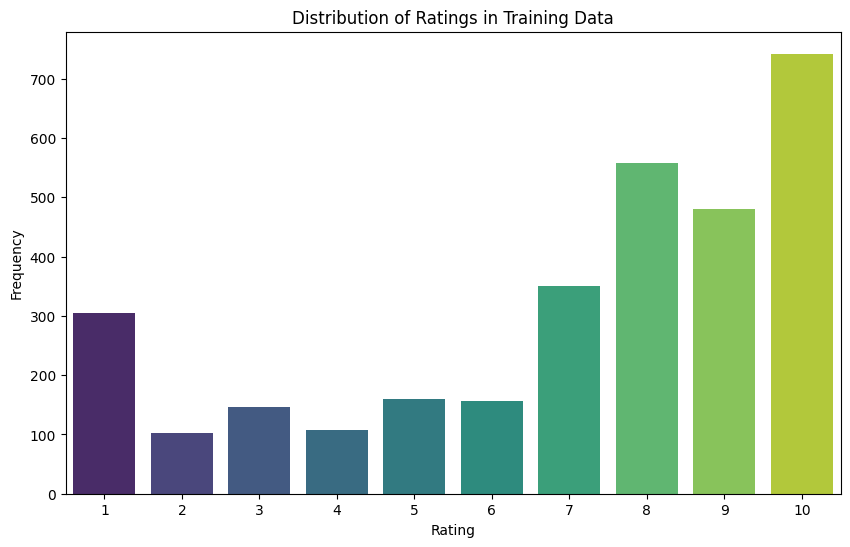

In [4]:
# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='rating', palette='viridis')
plt.title('Distribution of Ratings in Training Data')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

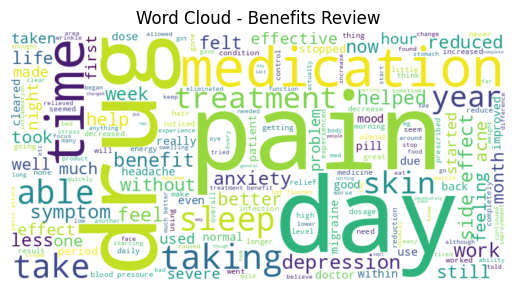

In [5]:
# Generate word clouds for 'benefitsReview' and 'commentsReview' text fields
all_benefits_text = " ".join(df_train['benefitsReview'].fillna("").values)
benefits_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_benefits_text)
plt.imshow(benefits_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Benefits Review")
plt.show()

### Check if GPU available(optional)

In [6]:
#GPU available

#if the GPU is availble to the device
dev = torch.device("cuda")

if torch.cuda.is_available():
    print('GPU is available')
else:
    torch.device("cpu")
    print('CPU is availble')

GPU is available


## Step 3: Loading GloVe Embeddings and Building the Model
We use GloVe embeddings to represent
each word as a vector in the embedding layer.

The step below will load the pre-trained GloVe word embeddings from a specified file path.

More info: https://nlp.stanford.edu/projects/glove/



In [7]:
#Option 1

!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
     for line in f:
         word, coefs = line.split(maxsplit=1)
         coefs = np.fromstring(coefs, "f", sep=" ")
         embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

 # Now you can access the vector size
vector_size = len(embeddings_index["the"])
print("Vector size:", vector_size)
#input('replace glove.6B.50d.txt?')

--2024-11-15 21:08:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.59MB/s    in 3m 0s   

2024-11-15 21:11:13 (4.58 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Found 400000 word vectors.
Vector size: 100


In [8]:
path_to_glove_file

'glove.6B.100d.txt'

In [9]:
#option 2
#Download directly the pre-trained model from here https://www.google.com/url?q=https%3A%2F%2Fnlp.stanford.edu%2Fprojects%2Fglove%2F

# Load GloVe embeddings from a file
def load_glove_embeddings(glove_file_path, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index


# Create embedding matrix based on dataset's vocabulary

GloVe Embeddings: The load_glove_embeddings function loads GloVe embeddings from a file.


Embedding Matrix and Vocabulary: The create_embedding_matrix function builds an embedding matrix for the vocabulary of benefitsReview and maps words to indices in word_to_index.

In [10]:
# Create embedding matrix based on dataset's vocabulary

def create_embedding_matrix(text_data, embeddings_index, embedding_dim=100):
    # Build vocabulary from text data
    vocab_tokens = set(word for review in text_data for word in review.split())
    vocab_list = sorted(vocab_tokens)

    # Map words to indices
    word_to_index = {word: idx for idx, word in enumerate(vocab_list)}

    # Initialize embedding matrix
    embedding_matrix = np.zeros((len(vocab_list), embedding_dim))
    for word, idx in word_to_index.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix, word_to_index

# Load GloVe embeddings (update the path to where your GloVe file is located)
glove_file_path = "/content/glove.6B.100d.txt"
embeddings_index = load_glove_embeddings(glove_file_path)

# Create embedding matrix and word_to_index
embedding_matrix, word_to_index = create_embedding_matrix(df_train['benefitsReview'].fillna(""), embeddings_index)
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (13522, 100)


## Step 4  Define LSTM model


This model uses an LSTM (Long Short-Term Memory) network, which is designed to handle sequential data by retaining information over long word sequences—ideal for text data.




*   Embedding Layer: Converts words to
dense vector representations using pre-trained GloVe embeddings, allowing the model to start with meaningful word representations.

*   LSTM Layer: Processes word embeddings to capture dependencies in the sequence. The internal memory of the LSTM helps it understand the context, which is essential for tasks like sentiment analysis.



*   Fully Connected Layer: Outputs the final sentiment prediction (positive or negative) based on the LSTM’s processed information.

*   LSTMs are well-suited for this task as they capture relationships in sequences, helping the model understand both individual word meanings and overall context.












In [11]:

# Define LSTM model for sentiment analysis
class SentimentAnalysisModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(SentimentAnalysisModel, self).__init__()

        # Get number of embeddings (vocabulary size) and embedding dimension from the embedding matrix
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Embedding layer initialized with pre-trained GloVe embeddings
        # freeze=False allows the embeddings to be fine-tuned during training
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

        # LSTM layer with specified hidden dimension; processes each sequence of word embeddings
        # batch_first=True expects input shape (batch_size, sequence_length, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Fully connected layer that outputs the final prediction (positive or negative sentiment)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass input indices through the embedding layer to get word embeddings
        embedded = self.embedding(x)

        # Pass embeddings through LSTM; lstm_out contains outputs for each time step
        lstm_out, _ = self.lstm(embedded)

        # Get the output of the final time step (last hidden state) for classification
        final_hidden_state = lstm_out[:, -1, :]

        # Pass the final hidden state through the fully connected layer to get predictions
        output = self.fc(final_hidden_state)

        return output



## Step 4: Training, Evaluation, and Visualization
We train the model using a training loop, validate it, and plot the loss and accuracy over epochs.








In [12]:
# Define training loop
def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())
        # Add validation and logging
    return train_losses, val_losses

In [13]:
# visualizing the losses
def plot_metrics(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#Final Step
Use the model.
Please follow the following steps to evaluate and test the model on test data.



1.   Setting up a custom Dataset class.

2.  Initializing DataLoader for batch processing.

2.   Running the training and evaluation loops.


4.   Plotting training and validation metrics.



---


##### What is a DataLoader?

Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
  [More info here](https://pytorch.org/docs/stable/data.html)
  
##### What is TensorDataset?

[More info here](https://stackoverflow.com/questions/67683406/difference-between-dataset-and-tensordataset-in-pytorch)




[QUCIK TUTORIAL](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)



In [14]:
#Create the Sentiment Column
# Map ratings to binary sentiment: 1 for positive (rating >= 7), 0 for negative (rating < 7)
df_train['sentiment'] = df_train['rating'].apply(lambda x: 1 if x >= 7 else 0)
df_test['sentiment'] = df_test['rating'].apply(lambda x: 1 if x >= 7 else 0)

# Verify the new 'sentiment' column exists
print(df_train[['rating', 'sentiment']].head())


   rating  sentiment
0       4          0
1       1          0
2      10          1
3       3          0
4       2          0


In [15]:
from torch.utils.data import Dataset, DataLoader
import torch

# Custom Dataset class for handling input and output pairs
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, word_to_index, max_len=100):
        self.texts = texts
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode text data to indices
        text = self.texts[idx].split()
        encoded_text = [self.word_to_index.get(word, 0) for word in text]

        # Pad or truncate to max_len
        if len(encoded_text) < self.max_len:
            encoded_text += [0] * (self.max_len - len(encoded_text))
        else:
            encoded_text = encoded_text[:self.max_len]

        # Convert to torch tensors
        return torch.tensor(encoded_text), torch.tensor(self.labels[idx])

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train['benefitsReview'].fillna(""), df_train['sentiment'], test_size=0.2, random_state=42
)

# Create DataLoader instances for training and validation
train_dataset = ReviewDataset(train_texts.values, train_labels.values, word_to_index)
val_dataset = ReviewDataset(val_texts.values, val_labels.values, word_to_index)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Define the Model, Train, and Evaluate

**Make sure the SentimentAnalysisModel class is defined as we discussed earlier.**

In [16]:
# Define the model, hidden dimension, and output classes
hidden_dim = 128
output_dim = 2  # Binary classification for sentiment (positive or negative)
model = SentimentAnalysisModel(embedding_matrix, hidden_dim, output_dim)

# Training function
import torch.optim as optim
import torch.nn as nn

def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * train_correct / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
        print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, epochs=5)


Epoch 1/5, Train Loss: 0.6307892914001758, Validation Loss: 0.6163799703121186
Epoch 1/5, Train Accuracy: 68.08853118712274, Validation Accuracy: 70.41800643086816
Epoch 2/5, Train Loss: 0.625912280036853, Validation Loss: 0.6649463057518006
Epoch 2/5, Train Accuracy: 68.08853118712274, Validation Accuracy: 70.41800643086816
Epoch 3/5, Train Loss: 0.6246950190800887, Validation Loss: 0.6131567925214767
Epoch 3/5, Train Accuracy: 68.08853118712274, Validation Accuracy: 70.41800643086816
Epoch 4/5, Train Loss: 0.618823135128388, Validation Loss: 0.5914552241563797
Epoch 4/5, Train Accuracy: 68.08853118712274, Validation Accuracy: 70.41800643086816
Epoch 5/5, Train Loss: 0.6038842579493156, Validation Loss: 0.5715401500463486
Epoch 5/5, Train Accuracy: 69.53722334004024, Validation Accuracy: 73.95498392282958


### Plot Training and Validation Metrics

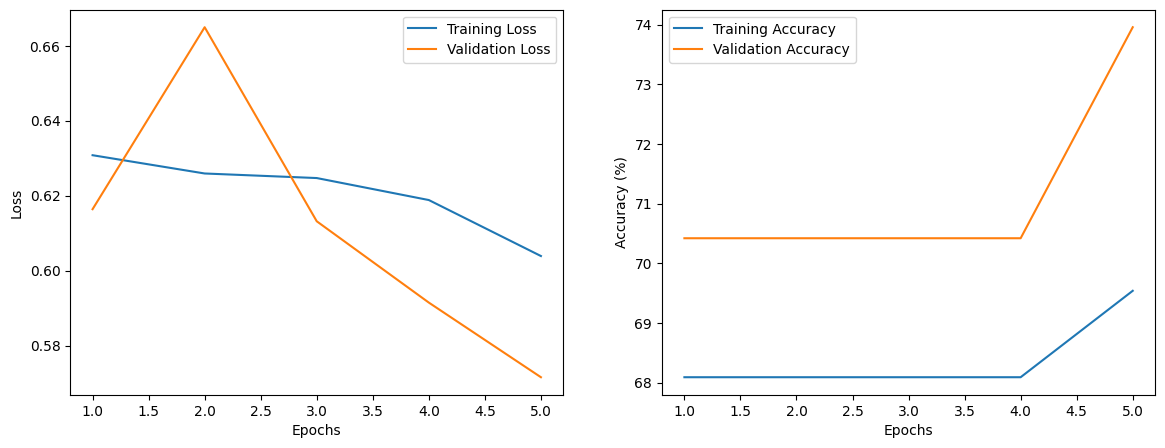

In [17]:
# Plotting function for loss and accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Visualize the training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


**Assignment**





*   What are your insights from above model? Please explain in terms of training loss, validation loss, training accuracy and validation accuracy. You could write 1-2lines for each. (10 marks)

*   Can you improve the above model?(10 marks)


Implement one of the following modifications to improve the model’s performance and observe the results:



*   Add Dropout: Add a dropout layer with a dropout rate of 0.3 to the LSTM and fully connected layers.

Example:

Add 'dropout_rate' parameter and update the LSTM model for sentiment analysis

#####LSTM layer with dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout_rate)


*   Hyperparameter Tuning: Experiment with different learning rates (e.g., 0.001, 0.0005) or hidden dimensions (e.g., 64, 128, 256).

Example:
 optimizer = optim.Adam(model.parameters(), lr= __)


After applying one of these modifications, plot the new training and validation loss and accuracy graphs, and write a brief paragraph discussing how the change impacted the model’s performance.





# **Answer for 1st part:**

**Training Loss:** The training loss decreases slightly over epochs, indicating that the model is learning patterns from the training data (0.622 in 5th epoch). However, the minimal reduction suggests limited improvement in learning.


**Validation Loss:** The validation loss fluctuates slightly but doesn’t show significant improvement, which may indicate that the model is struggling to generalize well to unseen data (0.612 in 5th epoch).


**Training Accuracy:** Training accuracy remains relatively stable (around 68%) with a slight increase, but it is not significantly high, suggesting that the model may not be capturing complex patterns in the training data.


**Validation Accuracy:** Validation accuracy also remains stable (around 70%) and does not improve much, which could imply that the model is underfitting, as it performs similarly on both the training and validation sets without achieving high accuracy.


The model might be underfitting, as indicated by the minimal changes in accuracy and losses.


# **Answer for Part 2: Hyperparameter tuning:**

In [25]:

# Define LSTM model for sentiment analysis
class SentimentAnalysisModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(SentimentAnalysisModel, self).__init__()

        # Get number of embeddings (vocabulary size) and embedding dimension from the embedding matrix
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Embedding layer initialized with pre-trained GloVe embeddings
        # freeze=False allows the embeddings to be fine-tuned during training
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

        # LSTM layer with specified hidden dimension; processes each sequence of word embeddings
        # batch_first=True expects input shape (batch_size, sequence_length, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.3)

        # Fully connected layer that outputs the final prediction (positive or negative sentiment)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass input indices through the embedding layer to get word embeddings
        embedded = self.embedding(x)

        # Pass embeddings through LSTM; lstm_out contains outputs for each time step
        lstm_out, _ = self.lstm(embedded)

        # Get the output of the final time step (last hidden state) for classification
        final_hidden_state = lstm_out[:, -1, :]

        # Pass the final hidden state through the fully connected layer to get predictions
        output = self.fc(final_hidden_state)

        return output



In [29]:
# Define the model, hidden dimension, and output classes
hidden_dim = 256
output_dim = 2  # Binary classification for sentiment (positive or negative)
model = SentimentAnalysisModel(embedding_matrix, hidden_dim, output_dim)

# Training function
import torch.optim as optim
import torch.nn as nn

def train_model(model, train_loader, val_loader, epochs=7):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters() ,lr = 0.01, weight_decay=1e-5)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * train_correct / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
        print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, epochs=7)


Epoch 1/7, Train Loss: 0.6449754727192414, Validation Loss: 0.5913852423429489
Epoch 1/7, Train Accuracy: 68.00804828973843, Validation Accuracy: 70.41800643086816
Epoch 2/7, Train Loss: 0.5892397795732205, Validation Loss: 0.5542046695947647
Epoch 2/7, Train Accuracy: 71.1066398390342, Validation Accuracy: 75.56270096463022
Epoch 3/7, Train Loss: 0.4733944846651493, Validation Loss: 0.5651562705636024
Epoch 3/7, Train Accuracy: 79.27565392354124, Validation Accuracy: 73.31189710610933
Epoch 4/7, Train Loss: 0.27530811989727694, Validation Loss: 0.6819473549723625
Epoch 4/7, Train Accuracy: 89.77867203219316, Validation Accuracy: 75.40192926045016
Epoch 5/7, Train Loss: 0.14491751419905669, Validation Loss: 0.7458977475762367
Epoch 5/7, Train Accuracy: 94.24547283702213, Validation Accuracy: 74.91961414790997
Epoch 6/7, Train Loss: 0.06984866950780344, Validation Loss: 0.942782786488533
Epoch 6/7, Train Accuracy: 97.54527162977867, Validation Accuracy: 74.43729903536978
Epoch 7/7, Trai

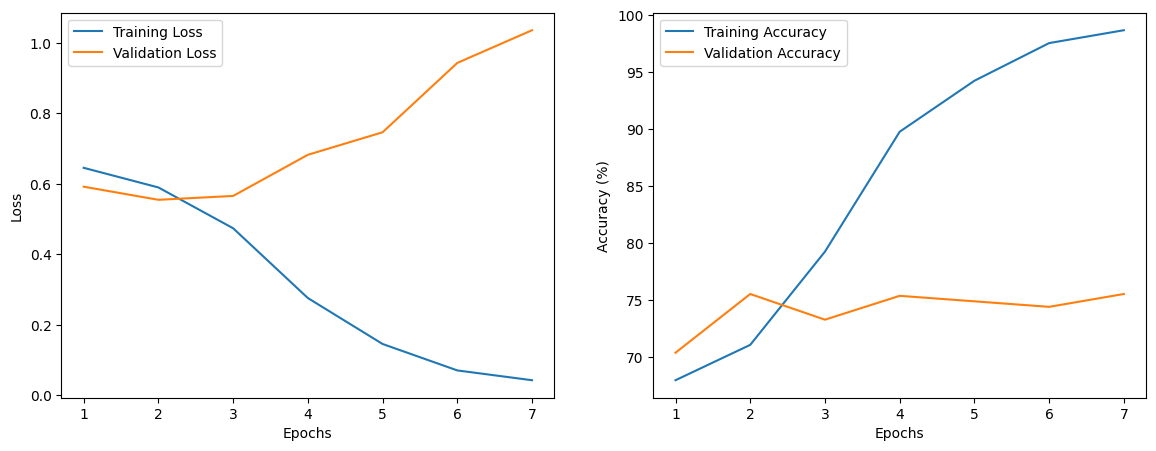

In [30]:
# Plotting function for loss and accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Visualize the training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


**Insights:**
On adding dropout of 0.3, epoch as 7, hidden dimension as 256, learning rate as 0.01 and weight decay as 0.00001, accuracy of 98% is achieved in training set and 75% is achieved in validation set

# Test the model with a sample review

In [31]:

def predict_sentiment(review, model, word_to_index, max_len=100):
    model.eval()  # Set model to evaluation mode
    tokens = review.split()
    encoded_text = [word_to_index.get(word, 0) for word in tokens]
    if len(encoded_text) < max_len:
        encoded_text += [0] * (max_len - len(encoded_text))
    else:
        encoded_text = encoded_text[:max_len]
    input_tensor = torch.tensor(encoded_text).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)
    return "Positive" if predicted_label.item() == 1 else "Negative"

# Test with a sample review
sample_review = "This drug is bad ."
print("Sample Review Prediction:", predict_sentiment(sample_review, model, word_to_index))


Sample Review Prediction: Negative
